<div style="text-align: center; background-color: #A52A2A; padding: 15px;">
  <h1 style="color: #fff; font-size: 35px;">Credit Card Fraud Detection</h1>
</div>

<img src='https://images.techhive.com/images/article/2014/12/credit_card_fraud-100537848-large.jpg?auto=webp&quality=85,70' style="display: block; margin: 0 auto;">

In [1]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, GridSearchCV, KFold, cross_val_score
from imblearn.under_sampling import RandomUnderSampler
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.metrics import precision_recall_curve, recall_score, auc, confusion_matrix, accuracy_score
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier

In [2]:
df = pd.read_csv('creditcard.csv')
print(df.shape)
df.head()

(284807, 31)


,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


In [3]:
class_values = df.Class.value_counts()

<div style="text-align: center; background-color: #A52A2A; padding: 10px;">
  <h2 style="color: #fff; font-size: 25px;">Imbalanced Class</h2>
</div>

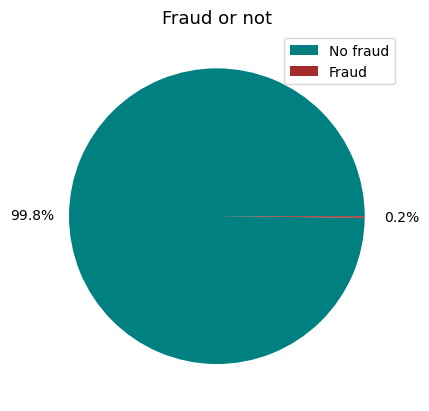

In [4]:
fig, ax = plt.subplots()

ax.pie(class_values.values, labels=class_values.index,
       autopct='%1.1f%%', pctdistance=1.25, labeldistance=None, colors=['#008080', '#A52A2A'])
ax.set_title('Fraud or not', fontsize=13)

legend = ax.legend()
legend.get_texts()[0].set_text('No fraud')
legend.get_texts()[1].set_text('Fraud')


plt.show()

- the class is imbalanced

### RandomUnderSampler
- To balance the data, we'll use the RandomUnderSampler from imblearn

In [5]:
X = df.drop('Class', axis=1)
y = df.Class

In [6]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)
print(X_train.shape, X_test.shape)

(227845, 30) (56962, 30)


In [7]:
y_train.value_counts()

Class
0    227451
1       394
Name: count, dtype: int64

In [8]:
rus = RandomUnderSampler(random_state=12)
X_res, y_res = rus.fit_resample(X_train, y_train)
print(X_res.shape)

(788, 30)


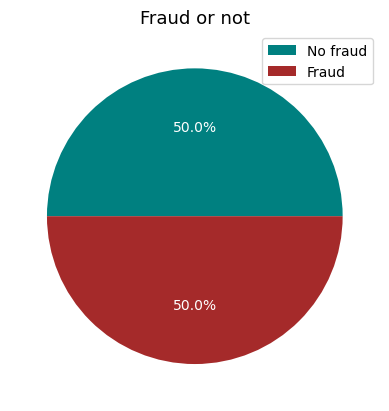

In [9]:
class_values = y_res.value_counts()

fig, ax = plt.subplots()

pie = ax.pie(class_values.values, labels=class_values.index,
             autopct=lambda p: '{:.1f}%'.format(p),
             labeldistance=None, colors=['#008080', '#A52A2A'])

for text in pie[2]:
    text.set_color('white')

ax.set_title('Fraud or not', fontsize=13)

legend = ax.legend()
legend.get_texts()[0].set_text('No fraud')
legend.get_texts()[1].set_text('Fraud')


plt.show()

<div style="text-align: center; background-color: #A52A2A; padding: 10px;">
  <h2 style="color: #fff; font-size: 25px;">Preprocessing</h2>
</div>

- let's normalize the data with StandardScaler

In [10]:
scaler = StandardScaler()

scaler.fit(X_res)

X_res[X_res.columns] = scaler.transform(X_res)

### PCA
- reducing the dimensionality of the dataset to 3 dimensions

In [11]:
pca = PCA(n_components=3)

pca.fit(X_res)

X_res_pca = pca.transform(X_res)

In [12]:
X_res_pca.shape, y_res.shape

((788, 3), (788,))

- visualizing the data in a 3d scatter plot

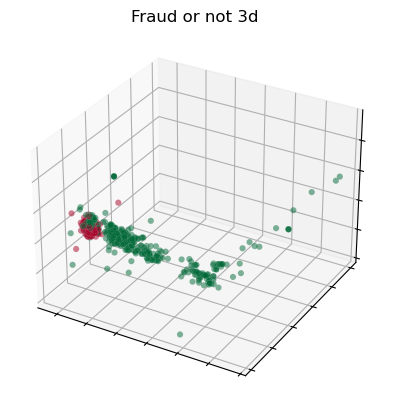

In [13]:
fig, ax = plt.subplots(subplot_kw={"projection": "3d"})

ax.scatter(X_res_pca[:,0], X_res_pca[:,1], X_res_pca[:,2], c=y_res, cmap='RdYlGn',
           edgecolor='white', linewidth=.1, alpha=.5)

ax.set(xticklabels=[],
       yticklabels=[],
       zticklabels=[])

ax.set_title('Fraud or not 3d', fontsize=12)

plt.show()

<div style="text-align: center; background-color: #A52A2A; padding: 10px;">
  <h2 style="color: #fff; font-size: 25px;">Machine Learning</h2>
</div>

- first, let's pre-processes the test data

In [14]:
X_test[X_test.columns] = scaler.transform(X_test)

In [15]:
X_test_pca = pca.transform(X_test)

### Precision-Recall curve
- since our data is unbalanced, the Precision-recall Curve will provide better information about the evaluation of our model

In [16]:
models = [
    RandomForestClassifier(),
    LogisticRegression(),
    SVC(probability=True),
    DecisionTreeClassifier(),
    KNeighborsClassifier()
]

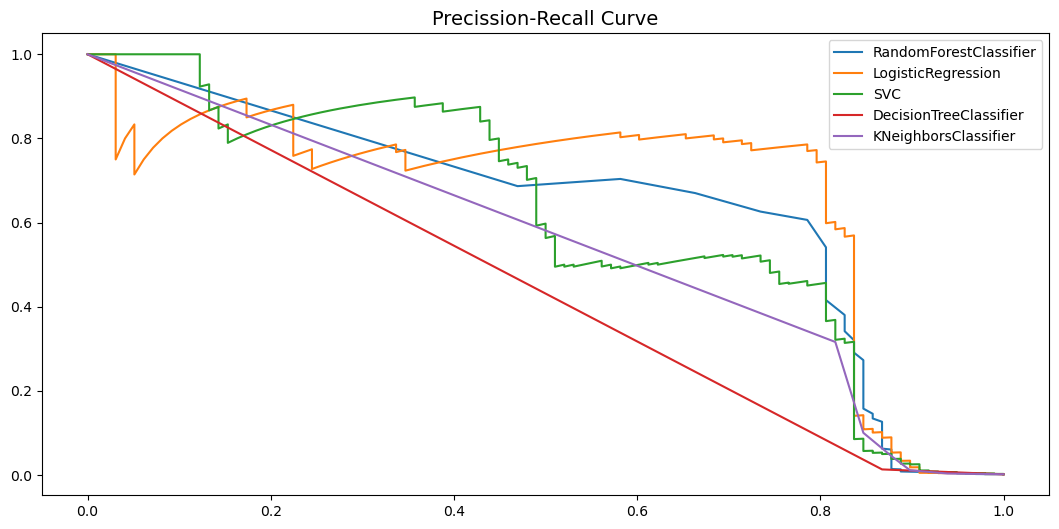

In [17]:
models_evaluate = pd.DataFrame(columns=['model', 'auc', 'recall'])

fig, ax = plt.subplots(figsize=(13, 6))

for model in models:
    model.fit(X_res_pca, y_res)
    
    name_model = model.__class__.__name__
    
    y_scores = model.predict_proba(X_test_pca)[:, 1]
    y_pred = model.predict(X_test_pca)
    
    precision, recall_curve, _ = precision_recall_curve(y_test, y_scores)
    ax.plot(recall_curve, precision, label=name_model)
    
    auc_pr = auc(recall_curve, precision)
    recall_value = recall_score(y_test, y_pred)
    
    models_evaluate.loc[len(models_evaluate)] = [name_model, round(auc_pr, 2), round(recall_value, 2)]   

ax.set_title('Precission-Recall Curve', fontsize=14)
ax.legend()
plt.show()

In [18]:
models_evaluate.sort_values(by='auc', ascending=False)

,model,auc,recall
1,LogisticRegression,0.67,0.84
0,RandomForestClassifier,0.64,0.88
2,SVC,0.61,0.84
4,KNeighborsClassifier,0.55,0.88
3,DecisionTreeClassifier,0.44,0.87


### GridSearchCV
- now we are going to make the best RandomForest and LogisticRegression models using GridSearchCV

#### Random Forest

In [19]:
rf_params = {
    'n_estimators': [50, 70, 80],
    'criterion': ['gini', 'entropy'],
    'max_features': ['sqrt', 'log2', None]
}

In [20]:
clf_rf = GridSearchCV(RandomForestClassifier(), param_grid=rf_params, scoring='recall')
clf_rf.fit(X_res_pca, y_res)
clf_rf.best_estimator_

RandomForestClassifier(n_estimators=50)

#### Logistic Regression

In [21]:
lr_params = {
    'C': [0.1, 1, 10],
    'solver': ['lbfgs', 'liblinear']
}

In [22]:
clf_lr = GridSearchCV(LogisticRegression(), param_grid=lr_params, scoring='recall')
clf_lr.fit(X_res_pca, y_res)
clf_lr.best_estimator_

LogisticRegression(C=10)

### Cross Validation
- now, it's time to compare these two models

In [23]:
kf = KFold(n_splits=5, shuffle=True, random_state=12)

results_rf = cross_val_score(clf_rf, X=X_res_pca, y=y_res, cv=kf, scoring='recall')
results_lr = cross_val_score(clf_lr, X=X_res_pca, y=y_res, cv=kf, scoring='recall')

print(f"RandomForest: \n mean => {np.mean(results_rf):.3f} \n std => {np.std(results_rf):.3f}")
print()
print(f"LogisticRegression: \n mean => {np.mean(results_lr):.3f} \n std => {np.std(results_lr):.3f}")

RandomForest: 
 mean => 0.865 
 std => 0.015

LogisticRegression: 
 mean => 0.825 
 std => 0.012


### Testing model
- RandomForest model scored higher than LogisticRegression
- let's test it on the test data

In [24]:
clf_rf.fit(X_res_pca, y_res)

GridSearchCV(estimator=RandomForestClassifier(),
             param_grid={'criterion': ['gini', 'entropy'],
                         'max_features': ['sqrt', 'log2', None],
                         'n_estimators': [50, 70, 80]},
             scoring='recall')

In [25]:
y_pred = clf_rf.predict(X_test_pca)

In [26]:
matrix = confusion_matrix(y_test, y_pred)

Accuracy: 96.4%
Recall: 87.8%


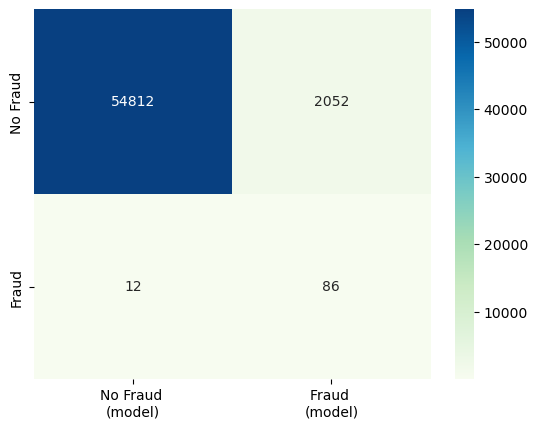

In [27]:
print(f'Accuracy: {(accuracy_score(y_test, y_pred) * 100):.1f}%')
print(f'Recall: {(recall_score(y_test, y_pred) * 100):.1f}%')

fig, ax = plt.subplots()

sns.heatmap(matrix, annot=True, cmap='GnBu', fmt='.0f', ax=ax)

ax.set_yticklabels(['No Fraud', 'Fraud'])
ax.set_xticklabels(['No Fraud \n(model)', 'Fraud \n(model)'])

plt.show()

- our model hits **87.8% of frauds**
- I could make models with better accuracy, but the recall would certainly be lower
- I believe that in this case, **the recall is the most important** because it deals directly with the frauds themselves, hitting the highest number of real frauds **(True Positive)**.